In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import uproot
import torch
import numpy as np
from matplotlib.ticker import FuncFormatter
from scipy.stats import multivariate_normal
import argparse
import os
import io
import gpytorch
import pickle
import seaborn as sns
from gpytorch.likelihoods import GaussianLikelihood
from entropy import entropy_local  
from create_config import create_config
from multitaskGPnD import MultitaskGP
from scipy.stats import qmc
import scipy.stats

### Two Circles

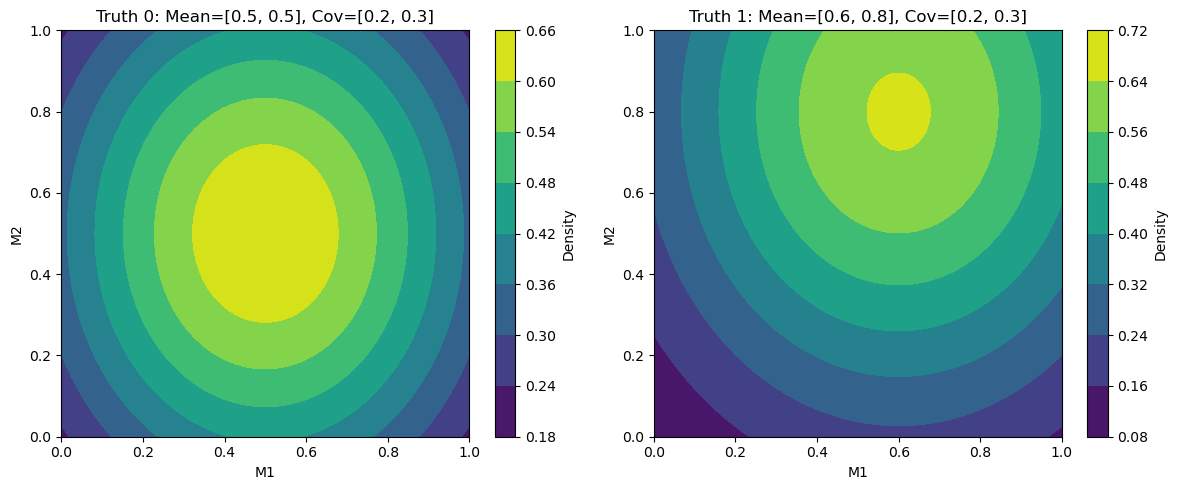

In [2]:
# Definiere den Bereich
x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100)
X, Y = np.meshgrid(x, y)
positions = np.dstack((X, Y))

# Truth-Funktionen
truth0 = multivariate_normal(mean=[0.5, 0.5], cov=np.diag([0.2, 0.3]))
truth1 = multivariate_normal(mean=[0.6, 0.8], cov=np.diag([0.2, 0.3]))

# Werte berechnen
Z0 = truth0.pdf(positions)
Z1 = truth1.pdf(positions)

# Plots
plt.figure(figsize=(12, 5))

# Plot truth0
plt.subplot(1, 2, 1)
plt.contourf(X, Y, Z0, cmap="viridis")
plt.colorbar(label="Density")
plt.title("Truth 0: Mean=[0.5, 0.5], Cov=[0.2, 0.3]")
plt.xlabel("M1")
plt.ylabel("M2")

# Plot truth1
plt.subplot(1, 2, 2)
plt.contourf(X, Y, Z1, cmap="viridis")
plt.colorbar(label="Density")
plt.title("Truth 1: Mean=[0.6, 0.8], Cov=[0.2, 0.3]")
plt.xlabel("M1")
plt.ylabel("M2")

plt.tight_layout()
plt.show()


### Toy Model Two Circles

In [6]:
def parse_args():
    parser = argparse.ArgumentParser(description='GP Model Pipeline')
    parser.add_argument('--iteration', type=int, required=True, help='Iteration number')
    parser.add_argument('--output_dir', type=str, required=True, help='Output directory')
    return parser.parse_args()

class GPModelPipeline:
    def __init__(self, output_dir=None, initial_train_points=10, valid_points=20, additional_points_per_iter=1):
        self.output_dir = output_dir
        self.initial_train_points = initial_train_points
        self.valid_points = valid_points
        self.additional_points_per_iter = additional_points_per_iter
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        self.likelihood = GaussianLikelihood().to(self.device)
        self.model = None
        self.best_model = None
        self.losses = None
        self.losses_valid = None
        self.x_train = None
        self.y_train = None
        self.x_valid = None
        self.y_valid = None
        self.observed_pred = None
        self.entropy = None

        x1_test = torch.linspace(0, 1, 100)
        x2_test = torch.linspace(0, 1, 100)
        x1_grid, x2_grid = torch.meshgrid(x1_test, x2_test)
        self.x_test = torch.stack([x1_grid.flatten(), x2_grid.flatten()], dim=1).to(self.device)

        self.truth0 = lambda X: np.atleast_1d(scipy.stats.multivariate_normal.pdf(X,mean = [0.5,0.5], cov = np.diag([0.2,0.3])))
        self.truth1 = lambda X: np.atleast_1d(scipy.stats.multivariate_normal.pdf(X,mean = [0.6,0.8], cov = np.diag([0.2,0.3])))

        self.load_initial_data()
        self.initialize_model()

    def load_initial_data(self):
        # Define the grid
        x_1 = torch.linspace(0, 1, 100)
        x_2 = torch.linspace(0, 1, 100)

        # Create a 2D grid of points
        grid_x1, grid_x2 = torch.meshgrid(x_1, x_2, indexing="ij")

        # Flatten the grid into coordinate pairs and convert to numpy for truth0
        grid_points = torch.stack([grid_x1.flatten(), grid_x2.flatten()], dim=-1).numpy()  # Shape [10000, 2]

        # Evaluate truth0 on the grid
        truth_values = self.truth0(grid_points) 

        # Convert back to torch tensors
        truth_values = torch.tensor(truth_values, dtype=torch.float32)

        # Select the first `initial_train_points` points for training
        self.x_train = torch.tensor(grid_points[:self.initial_train_points], dtype=torch.float32)
        self.y_train = truth_values[:self.initial_train_points]

        # Select the remaining points for validation
        self.x_valid = torch.tensor(grid_points[-self.initial_train_points:], dtype=torch.float32)
        self.y_valid = truth_values[-self.initial_train_points:]

        print("Initial Training Points:")
        print(f"X Train: {self.x_train}, Shape: {self.x_train.shape}")
        print(f"Y Train: {self.y_train}, Shape: {self.y_train.shape}")


    def load_additional_data(self, new_x):
    
        # Load new training points and evaluate truth function
        additional_x_train = torch.tensor(new_x).to(self.device)
        additional_y_train = torch.tensor(self.truth0(new_x)).to(self.device)

        # Debugging: Print shapes of both tensors before concatenating
        print(f"self.x_train shape: {self.x_train.shape}")  # Expecting [N, 2]
        print(f"additional_x_train shape: {additional_x_train.shape}")  # Should also be [M, 2]

        print(f"additional_x_train: {additional_x_train}")

        # Ensure the additional_x_train has the same number of columns as self.x_train
        if additional_x_train.shape[1] != self.x_train.shape[1]:
            additional_x_train = additional_x_train[:, :self.x_train.shape[1]]  # Adjust to the correct number of columns
        
        # Append the new points to the existing training data
        self.x_train = torch.cat((self.x_train, additional_x_train))
        self.y_train = torch.cat((self.y_train, additional_y_train))

        # Combine x_train (which is 2D) and y_train into tuples (x1, x2, y)
        combined_set = {(float(x1), float(x2), float(y.item())) for (x1, x2), y in zip(self.x_train, self.y_train)}

        # Unpack the combined_set into x_train and y_train
        x_train, y_train = zip(*[(x[:2], x[2]) for x in combined_set])

        # Convert the unpacked x_train and y_train back to torch tensors
        self.x_train = torch.tensor(list(x_train), dtype=torch.float32).to(self.device)
        self.y_train = torch.tensor(list(y_train), dtype=torch.float32).to(self.device)

        print("Training points after adding: ", self.x_train, self.x_train.shape)


    def initialize_model(self):
        self.model = MultitaskGP(self.x_train, self.y_train, self.x_valid, self.y_valid, self.likelihood, 2).to(self.device)

    def train_model(self, iters=20):
        print("These training_points are used in the GP", self.x_train)
        self.best_model, self.losses, self.losses_valid = self.model.do_train_loop(iters=iters)

        # Print the hyperparameters of the best model
        print("best model parameters: ", self.best_model.state_dict())


    def plot_losses(self):
        plt.plot(self.losses, label='training loss')
        plt.plot(self.losses_valid, label='validation loss')
        plt.yscale('log')
        plt.legend()
        plt.xlabel('Iterations')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss on Logarithmic Scale')
        plt.savefig(os.path.join(self.output_dir, 'loss_plot.png'))
        plt.show()

    def evaluate_model(self):
        self.model.eval()
        self.likelihood.eval()

        with torch.no_grad(), gpytorch.settings.fast_pred_var(False):
            self.observed_pred = self.likelihood(self.model(self.x_test))
            print("Likelihood", self.observed_pred)
            mean = self.observed_pred.mean.detach().reshape(-1, 1).to(self.device)
            print("Mean: ", mean)
            var = self.observed_pred.variance.detach().reshape(-1, 1).to(self.device)
            print("Variance: ", var)
            thr = torch.Tensor([0.]).to(self.device)


    def plotGP2D(self, new_x=None, save_path=None, iteration=None):
        '''Plot the 2D GP with a Heatmap and the new points and save it in the plot folder'''

        mean = self.observed_pred.mean.cpu().numpy()

        heatmap, xedges, yedges = np.histogram2d(self.x_test[:, 0].cpu().numpy(), self.x_test[:, 1].cpu().numpy(), bins=50, weights=mean)

        plt.figure(figsize=(8, 6))
        plt.imshow(heatmap.T, extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], origin='lower', cmap='inferno', aspect='auto')
        plt.colorbar(label='truth0')
        plt.xlabel('x_1')
        plt.ylabel('x_2')

        # Scatterplot of the training points
        # plt.scatter(self.x_train[:, 0].cpu().numpy(), self.x_train[:,1].cpu().numpy(), marker='*', s=200, c='b', label='training_points')

        # Contour wo mean > 0
        plt.contour(xedges[:-1], yedges[:-1], heatmap.T, levels=[0], colors='white', linewidths=2, linestyles='solid')

        # Add the iteration number to the plot title
        if iteration is not None:
            plt.title(f"GP Model Prediction - Iteration {iteration}")

        if save_path is not None:
            plt.savefig(save_path)
            print(f"Plot saved to {save_path}")
        else:
            plt.show()

    

    def best_not_yet_chosen(self, score, previous_indices):
        candidates = torch.sort(score, descending=True)[1].to(self.device)
        for next_index in candidates:
            if int(next_index) not in previous_indices:
                return next_index

    def iterative_batch_selector(self, score_function, 
                                 choice_function=None,
                                 gp_mean=None, 
                                 gp_covar=None, 
                                 N=None):
        '''Chooses the next points iterativley. The point with maximum entropy is always chosen first, 
            then the next indices are selected with the choice function - gibbs_sampling or best_not_yet_chosen
            The covariance matrix and the mean vector are updated iterativly, based on the already chosen points
        '''

        if gp_mean is None:
            def greedy_batch_sel(gp_mean, gp_covar, N):
                return self.iterative_batch_selector(score_function, choice_function, gp_mean, gp_covar, N)
            return greedy_batch_sel
        
        score = score_function(gp_mean[:, None], torch.diag(gp_covar)[:, None, None]).to(self.device)
        #print("Smoothed_batch_entropy: ", score)
        self.entropy = score
        first_index = torch.argmax(score).to(self.device)
        indices = [int(first_index)]

        num_pts = len(gp_mean)

        for i in range(N-1):
            center_cov = torch.stack([gp_covar[indices, :][:, indices]] * num_pts).to(self.device) # Covariance between selected points
            side_cov = gp_covar[:, None, indices].to(self.device) # Coveriance between already selected and remaining points
            bottom_cov = gp_covar[:, indices, None].to(self.device)
            end_cov = torch.diag(gp_covar)[:, None, None].to(self.device)

            cov_batch = torch.cat([
                torch.cat([center_cov, side_cov], axis=1),
                torch.cat([bottom_cov, end_cov], axis=1),
            ], axis=2).to(self.device)

            # print("Cov_batch Shape: ", cov_batch.shape)
            # print("center_cov Shape: ", center_cov.shape)
            # print("side_cov Shape: ", side_cov.shape)
            # print("bottom_cov Shape: ", bottom_cov.shape)
            # print("end_cov Shape: ", end_cov.shape)
            
            center_mean = torch.stack([gp_mean[indices]] * num_pts).to(self.device) # Mean between selected points
            # TODO: Sampling approach for a sampling mean
            # new_mean = torch.normal(mean=gp_mean, std=gp_covar.sqrt())
            new_mean = gp_mean[:, None].to(self.device) # Reshapes gp_mean to a column vector of shape (num_pts, 1)
            mean_batch = torch.cat([center_mean, new_mean], axis=1).to(self.device)

            # print("Mean_batch Shape: ", mean_batch.shape)
            # print("center_mean Shape: ", center_mean.shape)
            # print("new_mean Shape: ", new_mean.shape)

            score = score_function(mean_batch, cov_batch).to(self.device)
            next_index = choice_function(score, indices)
            indices.append(int(next_index))


        return indices

    def approximate_batch_entropy(self, mean, cov):
        device = self.device
        n = mean.shape[-1]
        d = torch.diag_embed(1. / mean).to(device)
        x = d @ cov @ d.to(device)
        # print("Cov Shape: ", cov.shape)
        # print("X Shape: ", x.shape)
        I = torch.eye(n)[None, :, :].to(device)
        return (torch.logdet(x + I) - torch.logdet(x + 2 * I) + n * np.log(2)) / np.log(2)

    def smoothed_batch_entropy(self, blur):
        return lambda mean, cov: self.approximate_batch_entropy(mean + blur * torch.sign(mean).to(self.device), cov)

    def gibbs_sample(self, beta):
        '''Chooses next point based on probability that a random value is smaller than the cumulative sum 
            of the probabilites. These are calculated with the smoothed batch entropy
            - if beta is high: deterministic selection with only highest entropies
            - if beta is low: more random selection with each point having a similar probility
        '''
        def sampler(score, indices=None):
            probs = torch.exp(beta * (score - torch.max(score))).to(self.device)
            probs /= torch.sum(probs).to(self.device)
            # print("probs:", probs)
            cums = torch.cumsum(probs, dim=0).to(self.device)
            # print("cumsum: ", cums)
            rand = torch.rand(size=(1,)).to(self.device)[0]
            # print("rand: ", rand)
            return torch.sum(cums < rand).to(self.device)    
        return sampler

    def select_new_points(self, N=4):
        # Initialize the selector using a combination of a smoothed batch entropy score function and a Gibbs sampling choice function.
        selector = self.iterative_batch_selector(
            score_function=self.smoothed_batch_entropy(blur=0.15),
            choice_function=self.gibbs_sample(beta=50)
            # choice_function=self.best_not_yet_chosen
        )

        with torch.no_grad(), gpytorch.settings.fast_pred_var(False):
            # Initialize a random x_test_rand to be able to choose new points out of the whole parameter space
            # # # Completly random 
            # x_test_rand = torch.rand(self.x_test.shape[0], 2).to(self.device)
            # Latin Hypercube
            x_test_rand = torch.tensor(qmc.LatinHypercube(d=2).random(n=self.x_test.shape[0]), dtype=torch.float32).to(self.device)

            # Evaluate the model
            self.model.eval()

            # Disable gradient computation for evaluation
            with torch.no_grad():
                # Get predictions of model for random test points
                predictions = self.model(x_test_rand)
                observed_pred = self.likelihood(predictions)

            mean = observed_pred.mean.detach().to(self.device)
            covar = observed_pred.covariance_matrix.detach().to(self.device)
            thr = torch.Tensor([0.]).to(self.device) 

            # Use the selector to choose a set of points based on the  mean and covariance matrix.
            points = set(selector(N=N, gp_mean=mean - thr, gp_covar=covar))  
            new_x = x_test_rand[list(points)]
            
        # Debugging and informational prints to check the selected points and their corresponding values.
        print("Selected points (indices):", points)
        print("Selected new x values (normalized):", new_x)
        
        return new_x
    
    def random_new_points(self, N=4):
        # TODO: adjust this method to random as well
        # Latin Hypercube
        x_test_rand = torch.tensor(qmc.LatinHypercube(d=2).random(n=self.x_test.shape[0]), dtype=torch.float32).to(self.device)
        # # Select random indices from the available test points
        # random_indices = np.random.choice(x_test_rand.shape[0], N, replace=False)  # Randomly select N indices

        # Latin Hypercube sampling
        # Define the number of samples and dimensions
        num_samples = N  # Number of indices to sample
        dimensions = 2  # Dimensionality of the space (e.g., 2 for x_test_rand)

        # Generate Latin Hypercube Samples
        sampler = qmc.LatinHypercube(d=dimensions)
        lhs_samples = sampler.random(n=num_samples)  # Generate N samples in [0, 1)

        # Map LHS samples to indices in x_test_rand
        lhs_indices = np.floor(lhs_samples[:, 0] * x_test_rand.shape[0]).astype(int)  # Use the first dimension for indices
        lhs_indices = np.clip(lhs_indices, 0, x_test_rand.shape[0] - 1)  # Ensure valid index range

        # Ensure indices are unique if necessary
        random_indices = np.unique(lhs_indices)[:N]  # Limit to N unique indices

        new_x = self.x_test[random_indices]

        return new_x

    
    def goodness_of_fit(self, test=None, csv_path=None):

        # Evaluate model at x_test
        input_data = self.x_test 

        # Calculate the true values (log-scaled)
        truth_values = self.truth0(input_data) 

        # Convert back to torch tensors
        true = torch.tensor(truth_values, dtype=torch.float32)

        self.model.eval()

        # Disable gradient computation for evaluation
        with torch.no_grad():
            predictions = self.model(input_data)

        observed_pred = self.likelihood(predictions)
        mean = observed_pred.mean.cpu().numpy()
        lower, upper = observed_pred.confidence_region()
        lower = lower.detach().cpu().numpy()
        upper = upper.detach().cpu().numpy()

        mean = torch.tensor(mean, dtype=torch.float32).to(self.device)
        upper = torch.tensor(upper, dtype=torch.float32).to(self.device)
        lower= torch.tensor(lower, dtype=torch.float32).to(self.device)

        # Define the various goodness_of_fit metrics
        def mean_squared():
            mse = torch.mean((mean - true) ** 2)
            rmse = torch.sqrt(mse)
            return mse.cpu().item(), rmse.cpu().item()
        
        def r_squared():
            ss_res = torch.sum((mean - true) ** 2)
            ss_tot = torch.sum((true - torch.mean(true)) ** 2)
            r_squared = 1 - ss_res / ss_tot
            return r_squared.cpu().item()
        
        def chi_squared():
            pull = (mean - true) / (upper - lower)
            chi_squared = torch.sum(pull ** 2)
            dof = len(true) - 1  # Degrees of freedom
            reduced_chi_squared = chi_squared / dof
            return chi_squared.cpu().item(), reduced_chi_squared.cpu().item()

        def average_pull():
            absolute_pull = torch.abs((mean - true) / (upper - lower))
            mean_absolute_pull = torch.mean(absolute_pull)
            root_mean_squared_pull = torch.sqrt(torch.mean((absolute_pull) ** 2))
            return mean_absolute_pull.cpu().item(), root_mean_squared_pull.cpu().item()

        # Weights for adjusting to threshold
        thr = 0.0
        epsilon = 0.1 # Tolerance area around threshold, considered close
        weights = torch.exp(-((true - thr) ** 2) / (2 * epsilon ** 2))  

        def mean_squared_weighted():
            mse_weighted = torch.mean(weights * (mean - true) ** 2)
            rmse_weighted = torch.sqrt(mse_weighted)
            return mse_weighted.cpu().item(), rmse_weighted.cpu().item()

        def r_squared_weighted():
            ss_res_weighted = torch.sum(weights * (mean - true) ** 2)
            ss_tot_weighted = torch.sum(weights * (true - torch.mean(true)) ** 2)
            r_squared_weighted = 1 - ss_res_weighted / ss_tot_weighted
            return r_squared_weighted.cpu().item()
        
        def chi_squared_weighted():
            pull_weighted = (mean - true) / (upper - lower)
            chi_squared_weighted = torch.sum(weights * pull_weighted ** 2)
            dof = len(true) - 1  # Degrees of freedom
            reduced_chi_squared_weighted = chi_squared_weighted / dof
            return chi_squared_weighted.cpu().item(), reduced_chi_squared_weighted.cpu().item()
        
        def average_pull_weighted():
            absolute_pull_weighted = torch.abs((mean - true) / (upper - lower))
            mean_absolute_pull_weighted = torch.mean(weights * absolute_pull_weighted)
            root_mean_squared_pull_weighted = torch.sqrt(torch.mean(weights * (absolute_pull_weighted) ** 2))
            return mean_absolute_pull_weighted.cpu().item(), root_mean_squared_pull_weighted.cpu().item()

        # Calculate classification matrix and accuracy
        def accuracy():
    
            # # TODO: Classification with uncertainty    
            # mean_plus = mean + (upper - lower)/2
            # mean_minus = mean + (upper - lower)/2

            TP = ((mean > 0) & (true > 0)).sum().item()  # True Positives
            FP = ((mean > 0) & (true < 0)).sum().item()  # False Positives
            FN = ((mean < 0) & (true > 0)).sum().item()  # False Negatives
            TN = ((mean < 0) & (true < 0)).sum().item()  # True Negatives

            total = TP + FP + FN + TN
            accuracy = (TP + TN) / total if total > 0 else 0

            return accuracy

            
        # Dictionary to map test names to functions
        tests = {
            'mean_squared': mean_squared,
            'r_squared': r_squared,
            'chi_squared': chi_squared,
            'average_pull': average_pull,
            'mean_squared_weighted': mean_squared_weighted,
            'r_squared_weighted': r_squared_weighted,
            'chi_squared_weighted': chi_squared_weighted,
            'average_pull_weighted': average_pull_weighted,
            'accurcay': accuracy
        }

        # If 'test' is None, run all tests and return the results
        if test is None:
            results = {}
            for test_name, test_function in tests.items():
                result = test_function()
                if isinstance(result, tuple):
                    for i, value in enumerate(result):
                        results[f"{test_name}_{i}"] = value  # Store each element of the tuple separately
                else:
                    results[test_name] = result  # Store single value directly

            # Save results to CSV if a path is provided
            if csv_path is not None:
                file_exists = os.path.isfile(csv_path)
                df_results = pd.DataFrame([results])  # Convert results to a DataFrame
                
                # Append data to CSV file, write header only if file does not exist
                df_results.to_csv(csv_path, mode='a', header=not file_exists, index=False)

            return results

        # Run a specific test
        if test in tests:
            result = tests[test]()
            print(f"Goodness of Fit ({test}): {result}")
            return result
        else:
            raise ValueError(f"Unknown test: {test}.")
        


# Utility functions
    def save_model(self, model_checkpoint_path):
        torch.save(self.model.state_dict(), model_checkpoint_path)

    def load_model(self, model_checkpoint_path):
        # Initialize the model architecture
        self.initialize_model()
        
        # Ensure the model loads on the correct device (GPU or CPU)
        map_location = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        # Load the saved state dict
        self.model.load_state_dict(torch.load(model_checkpoint_path, map_location=map_location))
        print(f"Model loaded from {model_checkpoint_path}")


### Test different pipeline

In [5]:
def run_pipeline_with_active_learning():
    import sys
    import os
    
    # Active Learning configuration
    ActiveLearning = True
    total_iterations = 10
    output_base_dir = '/u/dvoss/al_pmssmwithgp/model/plots/plots_two_circles'
    name = "two_circles"

    # Loop through iterations 1 to `total_iterations`
    for iteration in range(1, total_iterations + 1):
        output_dir = os.path.join(output_base_dir, f'Iter{iteration}')
        os.makedirs(output_dir, exist_ok=True)

        print(f"Starting Iteration {iteration} with Active Learning")

        # Initialize the pipeline
        if iteration == 1:
            gp_pipeline = GPModelPipeline(
                output_dir=output_dir, initial_train_points=10, valid_points=10, additional_points_per_iter=1
            )
        else:
            # Load previous data and add new training points
            gp_pipeline.load_additional_data(new_points)

        # Initialize, train, and evaluate the model
        gp_pipeline.initialize_model()
        gp_pipeline.train_model(iters=100)
        gp_pipeline.plot_losses()
        gp_pipeline.evaluate_model()

        # Active Learning - Select new points
        if ActiveLearning:
            new_points = gp_pipeline.select_new_points(N=1)
            gp_pipeline.goodness_of_fit(csv_path=f'{output_base_dir}/gof_{name}.csv')
            gp_pipeline.plotGP2D(
                new_x=new_points,
                save_path=os.path.join(output_dir, f'gp_plot_{name}.png'),
                iteration=iteration
            )
            gp_pipeline.save_model(os.path.join(output_dir, f'model_checkpoint_{name}.pth'))
        else:
            # Random selection
            new_points = gp_pipeline.random_new_points(N=50)
            gp_pipeline.goodness_of_fit(csv_path=f'{output_base_dir}/gof_{name}_rand.csv')
            gp_pipeline.plotGP2D(
                new_x=new_points,
                save_path=os.path.join(output_dir, f'gp_plot_{name}_rand.png'),
                iteration=iteration
            )
            gp_pipeline.save_model(os.path.join(output_dir, f'model_checkpoint_{name}_rand.pth'))

        print(f"Iteration {iteration} completed. Output saved to {output_dir}")


if __name__ == "__main__":
    run_pipeline_with_active_learning()


Starting Iteration 1 with Active Learning


TypeError: randn(): argument 'size' failed to unpack the object at pos 2 with error "type must be tuple of ints,but got NoneType"

In [ ]:
import cProfile
import pstats
from io import StringIO

In [ ]:
def run_pipeline():
    # Simulate command line arguments in Jupyter Notebook
    import sys
    sys.argv = ['ipykernel_launcher.py', '--iteration', '1', '--output_dir', '/path/to/output']

    args = parse_args()

    # Define Boolean to either do Active learning selection or random selection
    ActiveLearning = True

    previous_iter = args.iteration - 1
    previous_output_dir = f'/raven/u/dvoss/al_pmssmwithgp/model/plots_twocircles/Iter{previous_iter}'

    if ActiveLearning:
        training_data_path = os.path.join(previous_output_dir, 'training_data.pkl')
    else:
        training_data_path = os.path.join(previous_output_dir, 'training_data_rand.pkl')

    if args.iteration == 1:
        # First iteration, initialize with initial data
        gp_pipeline = GPModelPipeline(
            output_dir=args.output_dir, initial_train_points=5, valid_points=10, additional_points_per_iter=1
        )
    else:
        # Load previous training data and add new data from this iteration
        gp_pipeline = GPModelPipeline(
            output_dir=args.output_dir, initial_train_points=5, valid_points=10, additional_points_per_iter=1
        )
        gp_pipeline.load_additional_data(new_points)

    gp_pipeline.initialize_model()
    gp_pipeline.train_model(iters=1)
    gp_pipeline.plot_losses()
    gp_pipeline.evaluate_model()

    # Name plots dynamically
    name = "two_circles"
    # Plot with Active Learning new points
    if ActiveLearning:
        new_points = gp_pipeline.select_new_points(N=1)
        gp_pipeline.goodness_of_fit(csv_path=f'/u/dvoss/al_pmssmwithgp/model/gof_{name}.csv')
        gp_pipeline.plotGP2D(new_x=new_points, save_path=os.path.join(args.output_dir, f'gp_plot_{name}.png'), iteration=args.iteration)
        gp_pipeline.save_model(os.path.join(args.output_dir, f'model_checkpoint_{name}.pth'))
    # Plot with random chosen new points
    else:
        gp_pipeline.goodness_of_fit(csv_path=f'/u/dvoss/al_pmssmwithgp/model/gof_{name}_rand.csv')
        new_points = gp_pipeline.random_new_points(N=50)
        gp_pipeline.plotGP2D(new_x=new_points, save_path=os.path.join(args.output_dir, f'gp_plot_{name}_rand.png'), iteration=args.iteration)
        gp_pipeline.save_model(os.path.join(args.output_dir, f'model_checkpoint_{name}_rand.pth'))

In [ ]:
pr = cProfile.Profile()
pr.enable()

run_pipeline()

pr.disable()
s = StringIO()
sortby = 'cumulative'
ps = pstats.Stats(pr, stream=s).sort_stats(sortby)
ps.print_stats()
print(s.getvalue())

/u/dvoss/conda-envs/ALenv/lib/python3.11/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1716905990097/work/aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Initial Training Points:
X Train: tensor([[0.0000, 0.0000],
        [0.0000, 0.0101],
        [0.0000, 0.0202],
        [0.0000, 0.0303],
        [0.0000, 0.0404]]), Shape: torch.Size([5, 2])
Y Train: tensor([0.2293, 0.2331, 0.2370, 0.2408, 0.2446]), Shape: torch.Size([5])
These training_points are used in the GP tensor([[0.0000, 0.0000],
        [0.0000, 0.0101],
        [0.0000, 0.0202],
        [0.0000, 0.0303],
        [0.0000, 0.0404]])
Iteration 0: x_train shape: torch.Size([5, 2]), y_train shape: torch.Size([5])
Output mean shape: torch.Size([5])


KeyboardInterrupt: 